In [1]:
import seisbench.data as sbd
import seisbench.generate as sbg
import seisbench.models as sbm
from seisbench.util import worker_seeding

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
from torchsummary import summary
import visdom

set seed to get reproducible results

In [2]:
seed =0
torch.backends.cudnn.deterministic= True
torch.backends.cudnn.benchmark= False
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)


In [3]:
model = sbm.PhaseNet.from_pretrained("instance")

model.cuda();
summary(model, (3, 3001))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 8, 3001]              32
       BatchNorm1d-2              [-1, 8, 3001]              16
            Conv1d-3              [-1, 11, 751]             627
        Conv1dSame-4              [-1, 11, 751]               0
       BatchNorm1d-5              [-1, 11, 751]              22
            Conv1d-6              [-1, 16, 188]           1,248
        Conv1dSame-7              [-1, 16, 188]               0
       BatchNorm1d-8              [-1, 16, 188]              32
            Conv1d-9               [-1, 22, 47]           2,486
       Conv1dSame-10               [-1, 22, 47]               0
      BatchNorm1d-11               [-1, 22, 47]              44
           Conv1d-12               [-1, 32, 12]           4,960
       Conv1dSame-13               [-1, 32, 12]               0
      BatchNorm1d-14               [-1,

for param in model.parameters():
    param.requires_grad = False
    #print(param.requires_grad)

model.out.weight.requires_grad = True
model.up4.weight.requires_grad = True
#model.up3.weight.requires_grad = True
#model.up2.weight.requires_grad = True
#model.up1.weight.requires_grad = True
#model.conv4.conv.weight.requires_grad = True
#model.conv3.conv.weight.requires_grad = True

#for param in model.parameters():
    #param.requires_grad = False
    #print(param.requires_grad)

In [4]:
from collections import Counter
data = sbd.Iquique(sampling_rate=100)
#data = sbd.ETHZ(sampling_rate=100)
train, dev, test = data.train_dev_test()

2022-09-28 13:54:52,618 | seisbench | WARNING | Check available storage and memory before downloading and general use of Iquique dataset. Dataset size: waveforms.hdf5 ~5Gb, metadata.csv ~2.6Mb


In [5]:
generator = sbg.GenericGenerator(data)

@generator.augmentation
def print_state_dict(state_dict):
    print(state_dict)

generator[2];

{'X': (array([[198.29475309, 203.29475309, 210.29475309, ..., -28.70524691,
        -43.70524691, -61.70524691],
       [-67.81648663, -50.81648663, -49.81648663, ..., -91.81648663,
        -80.81648663, -66.81648663],
       [ 81.47247942,  66.47247942,  56.47247942, ..., -75.52752058,
        -55.52752058, -43.52752058]]), {'source_origin_time': '2014-05-01T00:52:20.970000Z', 'source_latitude_deg': -19.4527, 'source_longitude_deg': -69.9762, 'source_depth_km': 57.95, 'path_back_azimuth_deg': 329.936310182, 'station_network_code': 'DG', 'station_code': 'IN17', 'trace_channel': 'HH*', 'station_location_code': nan, 'station_latitude_deg': -20.48, 'station_longitude_deg': -69.35, 'station_elevation_m': 1278.0, 'trace_name': 'bucket0$2,:3,:15552', 'trace_sampling_rate_hz': 100, 'trace_completeness': 1.0, 'trace_has_spikes': False, 'trace_start_time': '2014-05-01T00:52:20.740000Z', 'trace_P_arrival_sample': 2000.0, 'trace_S_arrival_sample': 3551.0, 'trace_name_original': 'DG.IN17.', 'trace

In [6]:
phase_dict = {
    "trace_P_arrival_sample": "P",
    "trace_S_arrival_sample": "S",
}

In [7]:
train_generator = sbg.GenericGenerator(train)
dev_generator = sbg.GenericGenerator(dev)
test_generator = sbg.GenericGenerator(test)

augmentations = [
    sbg.WindowAroundSample(list(phase_dict.keys()), samples_before=3000, windowlen=6000, selection="random", strategy="variable"),
    sbg.RandomWindow(windowlen=3001, strategy="pad"),
    sbg.Normalize(demean_axis=-1, amp_norm_axis=-1, amp_norm_type="peak"),
    sbg.ChangeDtype(np.float32),
    sbg.ProbabilisticLabeller(label_columns=phase_dict, sigma=30, dim=0)
]

train_generator.add_augmentations(augmentations)
dev_generator.add_augmentations(augmentations)
test_generator.add_augmentations(augmentations)

In [8]:
batch_size = 256
num_workers = 4  # The number of threads used for loading data

train_loader = DataLoader(train_generator, batch_size=batch_size, shuffle=True, num_workers=num_workers, worker_init_fn=worker_seeding)
dev_loader = DataLoader(dev_generator, batch_size=batch_size, shuffle=False, num_workers=num_workers, worker_init_fn=worker_seeding)
test_loader = DataLoader(test_generator, batch_size=batch_size, shuffle=False, num_workers=num_workers, worker_init_fn=worker_seeding)

In [9]:
from collections import Counter
#print(dict(Counter(train_loader.batch_sampler)))

In [10]:
learning_rate = 1e-2
epochs = 70
loss_weight = torch.tensor([3.5, 1, 1]).to(model.device) # PSN
loss_weight = torch.reshape(loss_weight, (1,3,1))

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.01)
#loss_fn = torch.nn.CrossEntropyLoss()


def loss_fn(y_pred, y_true, eps=1e-5):
    # vector cross entropy loss
    #h = y_true * torch.log(y_pred + eps)
    h = y_true * torch.log(y_pred + eps)
    #print (h)
    h = h.mean(-1).sum(-1)  # Mean along sample dimension and sum along pick dimension
    h = h.mean()  # Mean over batch axis
    return -h


def fo_loss_fn(y_pred, y_true,gamma=3, eps=1e-5):
    # vector cross entropy loss
    #h = y_true * torch.log(y_pred + eps)
    h = (1-y_true)**gamma * torch.log(y_pred + eps)
    #print (h)
    h = h.mean(-1).sum(-1)  # Mean along sample dimension and sum along pick dimension
    h = h.mean()  # Mean over batch axis
    return -h


import torch
import torch.nn.functional as F
import torch.nn as nn

class FocalLoss(nn.Module):
    def __init__(self, alpha=1.0, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
    def forward(self, inputs, targets):
        '''
        :param inputs: batch_size * dim
        :param targets: (batch,)
        :return:
        '''
        bce_loss = F.cross_entropy(inputs, targets)
        loss = self.alpha * (1 - torch.exp(-bce_loss)) ** self.gamma * bce_loss
        return loss

focal_loss = FocalLoss()

In [11]:
def train_loop(dataloader):
    size = len(dataloader.dataset)
    for batch_id, batch in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(batch["X"].to(model.device))
        loss = loss_fn(pred, batch["y"].to(model.device))
        #loss = fo_loss_fn(pred, batch["y"].to(model.device))
        #loss = focal_loss(pred, batch["y"].to(model.device))
        #print (batch["y"])
        #break
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #scheduler.step()
        #vis = visdom.Visdom()

        #after calculating error per epoch
        #vis.line(Y=loss.cpu().detach().numpy().reshape(1,1), opts=dict(showlegend=True))
        #cc = loss.cpu().detach().numpy().reshape(1,1)
        #print(cc)
        #break
        
        if batch_id % 5 == 0:
            loss, current = loss.item(), batch_id * batch["X"].shape[0]
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        

def test_loop(dataloader):
    num_batches = len(dataloader)
    test_loss = 0

    with torch.no_grad():
        for batch in dataloader:
            pred = model(batch["X"].to(model.device))
            test_loss += loss_fn(pred, batch["y"].to(model.device)).item()
            #test_loss = focal_loss(pred, batch["y"].to(model.device)).item()

    test_loss /= num_batches
    print(f"Test avg loss: {test_loss:>8f} \n")

In [12]:

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader)
    model.eval()
    test_loop(dev_loader)
    test_loop(test_loader)

Epoch 1
-------------------------------
loss: 0.081118  [    0/ 8040]
loss: 0.072070  [ 1280/ 8040]
loss: 0.062543  [ 2560/ 8040]
loss: 0.062546  [ 3840/ 8040]
loss: 0.061468  [ 5120/ 8040]
loss: 0.058807  [ 6400/ 8040]
loss: 0.059462  [ 7680/ 8040]
Test avg loss: 0.059919 

Test avg loss: 0.060200 

Epoch 2
-------------------------------
loss: 0.060078  [    0/ 8040]
loss: 0.065924  [ 1280/ 8040]
loss: 0.061173  [ 2560/ 8040]
loss: 0.064386  [ 3840/ 8040]
loss: 0.056714  [ 5120/ 8040]
loss: 0.056625  [ 6400/ 8040]
loss: 0.060811  [ 7680/ 8040]
Test avg loss: 0.059621 

Test avg loss: 0.059989 

Epoch 3
-------------------------------
loss: 0.061927  [    0/ 8040]
loss: 0.059960  [ 1280/ 8040]
loss: 0.061945  [ 2560/ 8040]
loss: 0.062950  [ 3840/ 8040]
loss: 0.059785  [ 5120/ 8040]
loss: 0.056165  [ 6400/ 8040]
loss: 0.058624  [ 7680/ 8040]
Test avg loss: 0.056513 

Test avg loss: 0.058053 

Epoch 4
-------------------------------
loss: 0.059266  [    0/ 8040]
loss: 0.057508  [ 1280/ 

In [13]:
#bbbbbbbbbbbbbb
model.get_model_args()
model.device

device(type='cuda', index=0)

In [18]:
'''
client = Client("ETH")
t = UTCDateTime("2019-11-04T00:59:46.419800Z")
stream = client.get_waveforms(network="CH", station="EMING", location="*", channel="HH?", starttime=t-30, endtime=t+50)
out = model.annotate(stream)
'''
import pandas as pd
import numpy as np
from data_preprocessing import Data_Preprocessing
from picks_comparison import Picks_Comparison

start_year_analysis = 2012
start_day_analysis = 182
end_year_analysis = 2012
end_day_analysis = 182
time_lag_threshold = 450
P_th = 0.3
S_th = 0.15

obj = Data_Preprocessing (start_year_analysis, start_day_analysis,
                    end_year_analysis, end_day_analysis)

stream = obj.get_waveforms_chile()
#client = Client("GFZ")
stream = sbm.DeepDenoiser.from_pretrained("original").annotate(stream)

picks = model.classify(stream, batch_size=256, P_threshold=P_th, S_threshold=S_th, parallelism=1)

pick_df = []
for p in picks:
    pick_df.append({
        "id": p.trace_id,
        "timestamp": p.peak_time.datetime,
        "prob": p.peak_value,
        "type": p.phase.lower()
    })

event_picks = pd.DataFrame(pick_df)



picks_obj = Picks_Comparison (start_year_analysis, 
            start_day_analysis,
            end_year_analysis,
            end_day_analysis, event_picks)

all_dists_p, all_dists_s = picks_obj()


2022-10-01 22:40:37,233 | seisbench | WARNING | You are processing a large stream with the sequential asyncio implementation. Consider activating parallelisation. For details, see http://docs.seisbench.org/en/stable/pages/documentation/models.html#seisbench.models.base.WaveformModel.annotate
/home/javak/Transfer-Deep-Learning-chile-subduction-zone/transfer_learning/picks_comparison.py:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_S_picks[['station_code', 'others']] = df_S_picks['id'].str.split('.', 1, expand=True)
/home/javak/Transfer-Deep-Learning-chile-subduction-zone/transfer_learning/picks_comparison.py:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

f = event_picks[event_picks.prob>0.6]

picks_obj = Picks_Comparison (start_year_analysis, 
            start_day_analysis,
            end_year_analysis,
            end_day_analysis, f)

all_dists_p, all_dists_s = picks_obj()

In [15]:
event_picks.shape

(9001, 4)

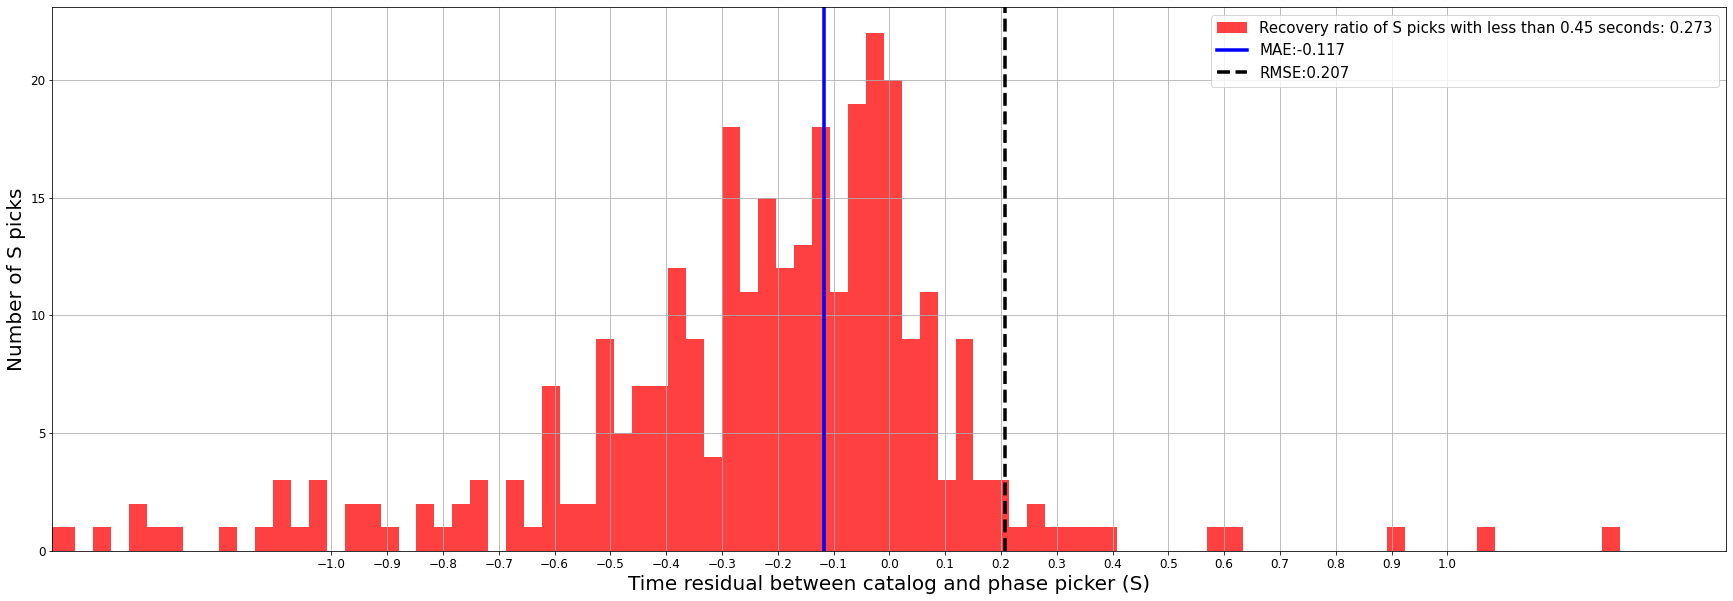

In [16]:
# Filter the time lag with the given threshold and capture the picks with more than .. second time lag
dists_filter_lag_time_m=all_dists_s[np.abs(all_dists_s) < 2000]/1000

# Perform S picks Quality control of PhaseNet by using existing S picks catalog with more than a given time lag
fig_lag_m, ax_lag_m = plt.subplots(figsize=(30,10))

label_more = '{0}{1}'.format('Recovery ratio of S picks with less than 0.45 seconds: ', round (all_dists_s[np.abs(all_dists_s) < time_lag_threshold].shape[0]/all_dists_s.shape[0],3))

n_lag_m, bins_lag_m, patches_lag_m = ax_lag_m.hist(dists_filter_lag_time_m, 100, density=False, facecolor='r', alpha=0.75, label=label_more)
#steps = (max(dists_filter_lag_time_m) - min(dists_filter_lag_time_m))/40
steps = 0.1
#plt.xticks(np.arange(min(dists_filter_lag_time_m), max(dists_filter_lag_time_m), step=steps))
plt.xticks(np.arange(-1, 1.1, step=steps))
plt.xlabel('Time residual between catalog and phase picker (S)', fontsize=20)
plt.ylabel('Number of S picks', fontsize=20)

plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)

filter_tim_lag = all_dists_s[np.abs(all_dists_s) < 450]/1000
MAE = np.sum(filter_tim_lag)/filter_tim_lag.shape[0]
RMSE = np.sqrt (np.sum(filter_tim_lag**2)/filter_tim_lag.shape[0])
plt.axvline(MAE, color='blue', label='MAE:'+str(round (MAE,3)),linewidth=3.5)
plt.axvline(RMSE, color='black', label='RMSE:'+str(round (RMSE,3)), linestyle="--", linewidth=3.5)

#plt.title('Common S picks distribution with less than 2 seconds time residual (2012-01-01 to 2012-12-31)', fontsize=24, pad=23)
#plt.xlim(min(bins_lag_m), max(bins_lag_m))
plt.xlim([-1.5,1.5])
plt.grid(True)
plt.legend(loc='upper right', fontsize=15)
plt.show()



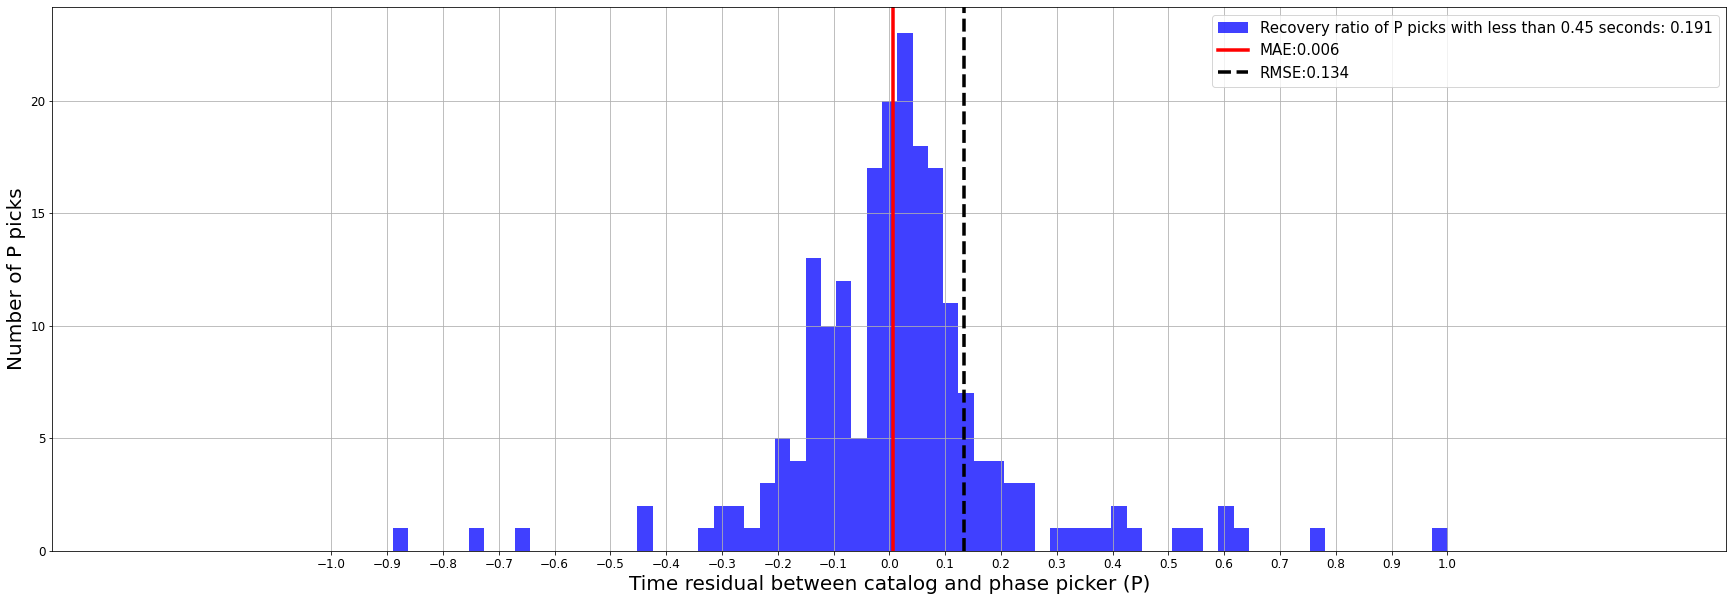

In [17]:
# Filter the time lag with the given threshold and capture the picks with more than .. second time lag
dists_filter_lag_time_m=all_dists_p[np.abs(all_dists_p) < 2000]/1000

# Perform S picks Quality control of PhaseNet by using existing S picks catalog with more than a given time lag
fig_lag_m, ax_lag_m = plt.subplots(figsize=(30,10))

label_more = '{0}{1}'.format('Recovery ratio of P picks with less than 0.45 seconds: ', round (all_dists_p[np.abs(all_dists_p) < time_lag_threshold].shape[0]/all_dists_p.shape[0],3))

n_lag_m, bins_lag_m, patches_lag_m = ax_lag_m.hist(dists_filter_lag_time_m, 100, density=False, facecolor='blue', alpha=0.75, label=label_more)
#steps = (max(dists_filter_lag_time_m) - min(dists_filter_lag_time_m))/40
steps = 0.1
#plt.xticks(np.arange(min(dists_filter_lag_time_m), max(dists_filter_lag_time_m), step=steps))
plt.xticks(np.arange(-1, 1.1, step=steps))
plt.xlabel('Time residual between catalog and phase picker (P)', fontsize=20)
plt.ylabel('Number of P picks', fontsize=20)

plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)

filter_tim_lag = all_dists_p[np.abs(all_dists_p) < 450]/1000
MAE = np.sum(filter_tim_lag)/filter_tim_lag.shape[0]
RMSE = np.sqrt (np.sum(filter_tim_lag**2)/filter_tim_lag.shape[0])
plt.axvline(MAE, color='r', label='MAE:'+str(round (MAE,3)),linewidth=3.5)
plt.axvline(RMSE, color='black', label='RMSE:'+str(round (RMSE,3)), linestyle="--", linewidth=3.5)

#plt.title('Common S picks distribution with less than 2 seconds time residual (2012-01-01 to 2012-12-31)', fontsize=24, pad=23)
#plt.xlim(min(bins_lag_m), max(bins_lag_m))
plt.xlim([-1.5,1.5])
plt.grid(True)
plt.legend(loc='upper right', fontsize=15)
plt.show()

